# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [12]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.322751
sanity check: 2.302585


**Inline Question 1**

Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

$\color{blue}{\textit Your Answer:}$ *It means the  softmax function's values is 0.1.The $f(x_i; W) =  W x_i$ is the probability. When we don't train the 'W', each one should have the same probability (1/10)* 



In [19]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -0.225782 analytic: -0.225782, relative error: 3.043692e-07
numerical: 1.672834 analytic: 1.672833, relative error: 2.254257e-08
numerical: -4.074295 analytic: -4.074295, relative error: 1.246171e-08
numerical: -5.868308 analytic: -5.868308, relative error: 2.905311e-09
numerical: -0.464788 analytic: -0.464788, relative error: 1.673222e-08
numerical: -0.821596 analytic: -0.821596, relative error: 2.815095e-08
numerical: 1.070628 analytic: 1.070628, relative error: 3.424864e-08
numerical: -2.871472 analytic: -2.871472, relative error: 3.148440e-09
numerical: 1.107685 analytic: 1.107685, relative error: 5.148014e-08
numerical: -4.676816 analytic: -4.676816, relative error: 1.622732e-08
numerical: 0.968755 analytic: 0.968755, relative error: 1.658615e-08
numerical: 0.881869 analytic: 0.881869, relative error: 2.528047e-08
numerical: -0.189553 analytic: -0.189553, relative error: 1.415349e-07
numerical: 0.365348 analytic: 0.365348, relative error: 2.282381e-08
numerical: 2.40794

In [29]:
scores = X_dev.dot(W)  # shape: (D,c)
scores -= np.max(scores,axis=1,keepdims=True)  #Numeric stabliity,use a normalization trick
softmax_function = np.exp(scores) / np.sum(np.exp(scores))
print(softmax_function.shape)
#print(softmax_function[y_dev].shape)
print(scores[np.arange(500),y_dev].shape)
loss = np.sum(-np.log(softmax_function[np.arange(500),y_dev]))
loss /= 500

print(loss)

loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

(500, 10)
(500, 10)
(500,)
8.556475142361638
loss: 2.322751
sanity check: 2.302585


In [37]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.322751e+00 computed in 0.247857s
vectorized loss: 2.322751e+00 computed in 0.007998s
Loss difference: 0.000000
Gradient difference: 0.000000


In [39]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 5e-7]
regularization_strengths = [2.5e4, 5e4]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

learning_rates = np.linspace(learning_rates[0],learning_rates[1],4)
regularization_strengths = np.linspace(regularization_strengths[0],regularization_strengths[1],4)

for lr in learning_rates:
    for reg in regularization_strengths:
        softmax = Softmax()
        loss_hist = softmax.train(X_train, y_train, learning_rate=lr, reg=reg,
                              num_iters=1500, verbose=True)
        y_train_pred = softmax.predict(X_train)
        train_accuracy = np.mean(y_train == y_train_pred)
        y_val_pred = softmax.predict(X_val)
        val_accuracy = np.mean(y_val == y_val_pred)
        results[(lr,reg)] = (train_accuracy,val_accuracy)
        if val_accuracy > best_val:
            best_val = val_accuracy
            best_softmax = softmax

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1500: loss 391.176582
iteration 100 / 1500: loss 236.150101
iteration 200 / 1500: loss 143.236000
iteration 300 / 1500: loss 87.501544
iteration 400 / 1500: loss 53.725411
iteration 500 / 1500: loss 33.313842
iteration 600 / 1500: loss 20.947352
iteration 700 / 1500: loss 13.483469
iteration 800 / 1500: loss 8.958574
iteration 900 / 1500: loss 6.214928
iteration 1000 / 1500: loss 4.529613
iteration 1100 / 1500: loss 3.533306
iteration 1200 / 1500: loss 2.982165
iteration 1300 / 1500: loss 2.586658
iteration 1400 / 1500: loss 2.342246
iteration 0 / 1500: loss 519.942843
iteration 100 / 1500: loss 265.778242
iteration 200 / 1500: loss 136.842576
iteration 300 / 1500: loss 71.037975
iteration 400 / 1500: loss 37.299016
iteration 500 / 1500: loss 20.038569
iteration 600 / 1500: loss 11.321859
iteration 700 / 1500: loss 6.807521
iteration 800 / 1500: loss 4.445658
iteration 900 / 1500: loss 3.372835
iteration 1000 / 1500: loss 2.608926
iteration 1100 / 1500: loss 2.352075
iter

iteration 0 / 1500: loss 775.798467
iteration 100 / 1500: loss 6.902905
iteration 200 / 1500: loss 2.127812
iteration 300 / 1500: loss 2.097054
iteration 400 / 1500: loss 2.114915
iteration 500 / 1500: loss 2.075703
iteration 600 / 1500: loss 2.108757
iteration 700 / 1500: loss 2.079414
iteration 800 / 1500: loss 2.091017
iteration 900 / 1500: loss 2.101017
iteration 1000 / 1500: loss 2.069332
iteration 1100 / 1500: loss 2.068922
iteration 1200 / 1500: loss 2.123861
iteration 1300 / 1500: loss 2.061334
iteration 1400 / 1500: loss 2.064574
lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.349939 val accuracy: 0.357000
lr 1.000000e-07 reg 3.333333e+04 train accuracy: 0.344837 val accuracy: 0.355000
lr 1.000000e-07 reg 4.166667e+04 train accuracy: 0.334163 val accuracy: 0.350000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.328143 val accuracy: 0.348000
lr 2.333333e-07 reg 2.500000e+04 train accuracy: 0.350286 val accuracy: 0.354000
lr 2.333333e-07 reg 3.333333e+04 train accuracy: 0

In [40]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.360000


**Inline Question 2** - *True or False*

Suppose the overall training loss is defined as the sum of the per-datapoint loss over all training examples. It is possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

$\color{blue}{\textit Your Answer:}$True


$\color{blue}{\textit Your Explanation:}$ The Softmax classifier is never fully happy with the scores it produces: the correct class could always have a higher probability and the incorrect classes always a lower probability and the loss would always get better. However, the SVM is happy once the margins are satisfied and it does not micromanage the exact scores beyond this constraint.



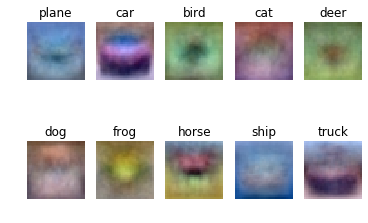

In [41]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])